# **Importations des bibliothèques:**

In [1]:

# ## Importer les bibliothèques pour la manipulation des données
import pandas as pd

## Faire appel aux fonctions du fichier init.py
import utils.utils_exploratoire as func

# Importer les bibliothèques pour la transformation des textes

import spacy
# nlp = spacy.load("en_core_web_sm")

# Charger le modèle spaCy en anglais
import en_core_web_sm
nlp = spacy.load('en_core_web_sm', exclude=['tok2vec', 'ner', 'parser', 'attribute_ruler', 'lemmatizer'])
nlp = en_core_web_sm.load()

# Définir les stop words de spaCy
stop_words = nlp.Defaults.stop_words

# Importer les bibliothèques pour la vectorisation des textes
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Importer les bibliothèques pour la séparation des données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bille\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bille\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bille\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bille\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bille\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Analyse exploratoire des données de Stack Overflow**
Ce notebook regroupe les travaux d'analyse exploratoire de données issues de données importées via l'outil StackExchange Data Explorer.

### Charger les données:

In [2]:
df = pd.read_csv('data/stack_overflow_data.csv')
display(df.head())
print(df.shape)

,Id,Title,Body,Tags,Score,ViewCount,AnswerCount
0,2003505,How do I delete a Git branch locally and remot...,<p>Failed Attempts to Delete a Remote Branch:<...,<git><version-control><git-branch><git-push><g...,20374,11748306,41
1,16956810,Find all files containing a specific text (str...,<p>How do I find all files containing a specif...,<linux><text><grep><directory><find>,7541,11199700,56
2,1125968,"How do I force ""git pull"" to overwrite local f...",<p>How do I force an overwrite of local files ...,<git><version-control><overwrite><git-pull><gi...,9728,8715122,54
3,4366730,How do I check if a string contains a specific...,<p>Consider:</p>\n\n<pre><code>$a = 'How are y...,<php><string><substring><contains><string-matc...,2653,6745591,36
4,11346283,Renaming column names in Pandas,<p>I want to change the column labels of a Pan...,<python><pandas><replace><dataframe><rename>,2997,6602832,33


(50000, 7)


### Traitement des valeurs manaquantes (Taux de remplissage):

In [3]:
func.taux_de_Remplissage_tableau(df, affichage_all = True)

,Colonne,Taux_de_Remplissage
0,Id,100.0
1,Title,100.0
2,Body,100.0
3,Tags,100.0
4,Score,100.0
5,ViewCount,100.0
6,AnswerCount,100.0


#### Conclusion:
D'après les informations fournies sur le taux de remplissage des colonnes du DataFrame extrait de Stack Overflow, je peux conclure que les données sont complètes et ne contiennent pas de valeurs manquantes pour les colonnes suivantes : Id, Title, Body, Tags, Score, ViewCount et AnswerCount.

## **Traiter les tags:**

#### Séparer les tags en une liste

In [4]:
# Appliquer la fonction à la colonne 'Tags'
df['split_tags'] = df['Tags'].apply(func.split_tags)

# Correct 'c#' tokens
df['split_tags'] = df['split_tags'].apply(lambda x: ['c#' if token == 'c' else token for token in x])


In [5]:
display(df.head())

,Id,Title,Body,Tags,Score,ViewCount,AnswerCount,split_tags
0,2003505,How do I delete a Git branch locally and remot...,<p>Failed Attempts to Delete a Remote Branch:<...,<git><version-control><git-branch><git-push><g...,20374,11748306,41,"[git, version, control, git, branch, git, push..."
1,16956810,Find all files containing a specific text (str...,<p>How do I find all files containing a specif...,<linux><text><grep><directory><find>,7541,11199700,56,"[linux, text, grep, directory, find]"
2,1125968,"How do I force ""git pull"" to overwrite local f...",<p>How do I force an overwrite of local files ...,<git><version-control><overwrite><git-pull><gi...,9728,8715122,54,"[git, version, control, overwrite, git, pull, ..."
3,4366730,How do I check if a string contains a specific...,<p>Consider:</p>\n\n<pre><code>$a = 'How are y...,<php><string><substring><contains><string-matc...,2653,6745591,36,"[php, string, substring, contains, string, mat..."
4,11346283,Renaming column names in Pandas,<p>I want to change the column labels of a Pan...,<python><pandas><replace><dataframe><rename>,2997,6602832,33,"[python, pandas, replace, dataframe, rename]"


In [6]:
df.Body[2]

"<p>How do I force an overwrite of local files on a <code>git pull</code>? My local repository contains a file of the same filename as on the server.</p>\n<blockquote>\n<p>error: Untracked working tree file 'example.txt' would be overwritten by merge</p>\n</blockquote>\n"

#### Extraire le corpus de tags et les Tags Uniques dans la colonne split_tags:

Je vais extraire le corpus des tags, afficher la liste des tags uniques dans ce corpus, puis l'utiliser pour montrer la répartition des types de noms et de verbes,.... Ces informations seront utilisées pour la fonction de nettoyage de texte des titles et bodys pour extraire uniquement les noms:

Construction du corpus tags:

In [7]:
# Combiner tous les tags en une seule liste de corpus
corpus_tags = [tag for sublist in df['split_tags'] for tag in sublist]

# Afficher une petite phrase avec les 10 premiers tags du corpus
print("Les 10 premiers tags du corpus sont :", corpus_tags[:10])

Les 10 premiers tags du corpus sont : ['git', 'version', 'control', 'git', 'branch', 'git', 'push', 'git', 'remote', 'linux']


In [8]:
# Afficher les informations des tokens
func.display_tokens_infos(corpus_tags)

Nombre de tokens: 316713
Nombre de tokens uniques: 10800

Exemple de tokens: ['git', 'version', 'control', 'git', 'branch', 'git', 'push', 'git', 'remote', 'linux', 'text', 'grep', 'directory', 'find', 'git', 'version', 'control', 'overwrite', 'git', 'pull', 'git', 'fetch', 'php', 'string', 'substring', 'contains', 'string', 'matching', 'python', 'pandas'] 



Création de liste unique tags:

In [9]:
# Créer la liste des tags distincts
unique_tags = list(set(corpus_tags))

# Afficher une petite phrase avec les 10 premiers tags distincts
print("Les 10 premiers tags distincts sont :", unique_tags[:10])

# Afficher le nombre total de tags distincts
print("Le nombre total de tags distincts est :", len(unique_tags))

Les 10 premiers tags distincts sont : ['throws', 'qheaderview', 'form', 'linkedin', 'smartgwt', 'csdl', 'chm', 'libavcodec', 'inequality', 'veracode']
Le nombre total de tags distincts est : 10800


Affichage des value counts du corpus tags:

In [10]:
# Afficher la fréquence de chaque tag dans le corpus
value_counts_tags = pd.Series(corpus_tags).value_counts()
print("Fréquence de chaque tag dans le corpus :\n\n",value_counts_tags)

Fréquence de chaque tag dans le corpus :

 python        8765
java          8045
android       6718
javascript    6657
c#            6222
              ... 
bindingpry       1
texinfo          1
bitcoind         1
feof             1
qtoolbar         1
Length: 10800, dtype: int64


#### Word cloud des tags:

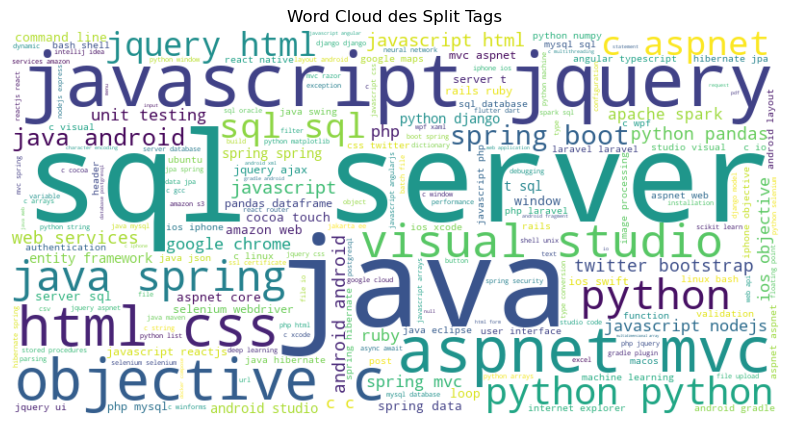

In [12]:
func.generate_wordcloud(corpus_tags, title = 'Word Cloud des Split Tags')

#### Conclusion

Le word cloud des tags montre les mots les plus fréquents dans les questions de Stack Overflow :

- **Technologies Populaires** : "javascript", "java", "sql".
- **Frameworks et Bibliothèques** : "aspnet", "spring", "mvc".
- **Langages de Programmation** : "java", "python", "c#".

#### Points Clés :

- Les technologies les plus populaires incluent JavaScript, Java, et SQL, montrant leur large adoption dans le développement web et d'applications.
- Les frameworks et bibliothèques comme ASP.NET, Spring, et MVC sont fréquemment mentionnés, reflétant leur utilisation courante.
- Les langages de programmation comme Java, Python, et C# montrent une diversité dans les technologies utilisées par les développeurs.

#### Analyse des Catégories de Tags

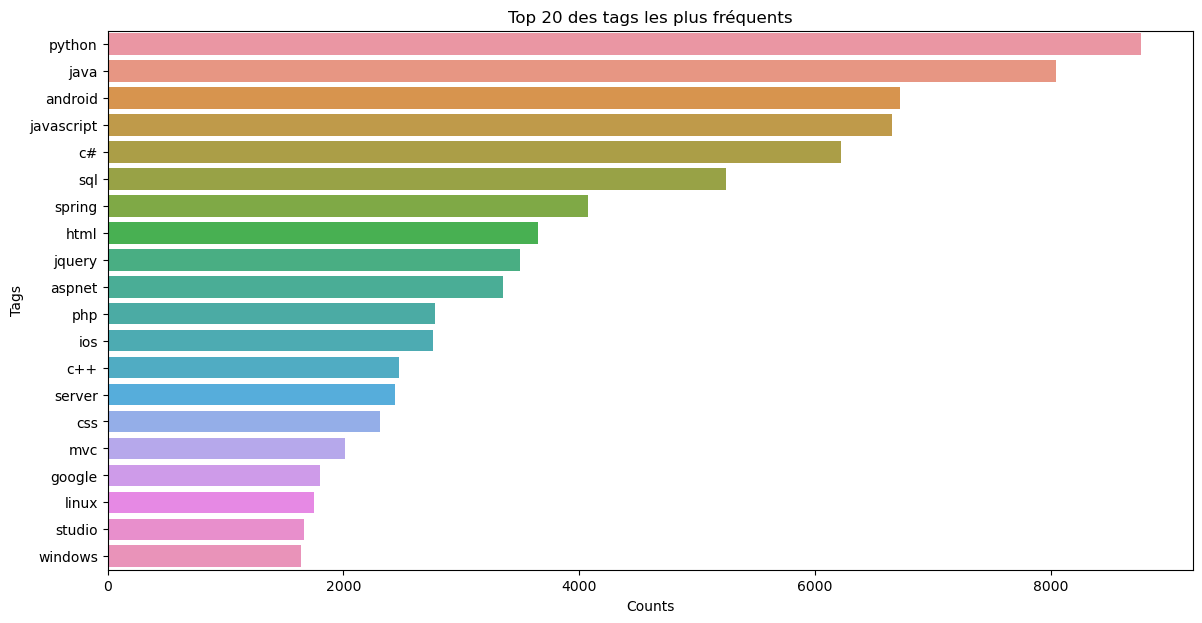

In [13]:
func.visualize_top_tags(corpus_tags)

### Conclusion

- **Python** est de loin le tag le plus populaire, indiquant son importance majeure dans le développement logiciel.
- **Java** et **JavaScript** sont largement utilisés, reflétant leur adoption continue dans divers domaines de la programmation et du développement web.
- **C#** et **SQL** montrent leur pertinence, en particulier dans le développement d'applications backend et d'applications d'entreprise.
- **Spring** et **ASP.NET** sont très fréquents, soulignant l'importance des frameworks pour le développement web.
- **Android** est un tag important, ce qui indique une forte activité dans le développement d'applications mobiles.
- **HTML** et **CSS** sont des éléments de base du développement web, ce qui n'est pas surprenant de les voir parmi les tags les plus fréquents.
- **PHP** et **C++** restent des langages essentiels pour de nombreux développeurs, notamment dans le développement de logiciels système et d'applications web backend.
- **JQuery** et **MVC** montrent l'importance des bibliothèques et des architectures de développement dans la création d'applications web interactives.
- **Google** et **Linux** sont des technologies couramment mentionnées, reflétant leur rôle crucial dans les environnements de développement et les infrastructures.
- **Studio** et **Windows** sont également des tags fréquents, indiquant leur utilisation dans le développement de logiciels et d'applications.

Le graphique des tags les plus fréquents sur Stack Overflow montre les technologies et langages les plus utilisés, fournissant des insights précieux pour orienter l'apprentissage et le développement de carrière en fonction des tendances actuelles du marché.

### Extraire les catégories grammaticales de la liste unique_tags :

In [14]:
filtered_pos_counts = func.analyze_pos_tags(unique_tags)

Tags avec catégories grammaticales : [('throws', 'NNS'), ('qheaderview', 'VBP'), ('form', 'JJ'), ('linkedin', 'NN'), ('smartgwt', 'NN'), ('csdl', 'NN'), ('chm', 'NN'), ('libavcodec', 'JJ'), ('inequality', 'NN'), ('veracode', 'NN'), ('forum', 'NN'), ('tdd', 'NN'), ('finance', 'NN'), ('built', 'VBD'), ('decompiling', 'VBG'), ('require', 'NN'), ('keep', 'VB'), ('anti', 'JJ'), ('intuit', 'NN'), ('xul', 'NNP'), ('entityreference', 'NN'), ('podfile', 'NN'), ('geotools', 'NNS'), ('look', 'VBP'), ('prisma2', 'JJ'), ('calculus', 'JJ'), ('classpath', 'NN'), ('implicitwait', 'NN'), ('tee', 'NN'), ('ionic5', 'NN'), ('gym', 'NN'), ('archetype', 'NN'), ('squared', 'VBD'), ('ethersjs', 'JJ'), ('dnf', 'NN'), ('jndi', 'NN'), ('bad', 'JJ'), ('alert', 'JJ'), ('addition', 'NN'), ('subquery', 'NN'), ('installed', 'VBD'), ('expected', 'VBN'), ('pressed', 'JJ'), ('plagiarism', 'NN'), ('asposewords', 'NNS'), ('operationcontext', 'IN'), ('idf', 'JJ'), ('mkannotationview', 'NN'), ('detectron', 'NN'), ('mapi', '

Visualisation des catégories grammaticales:

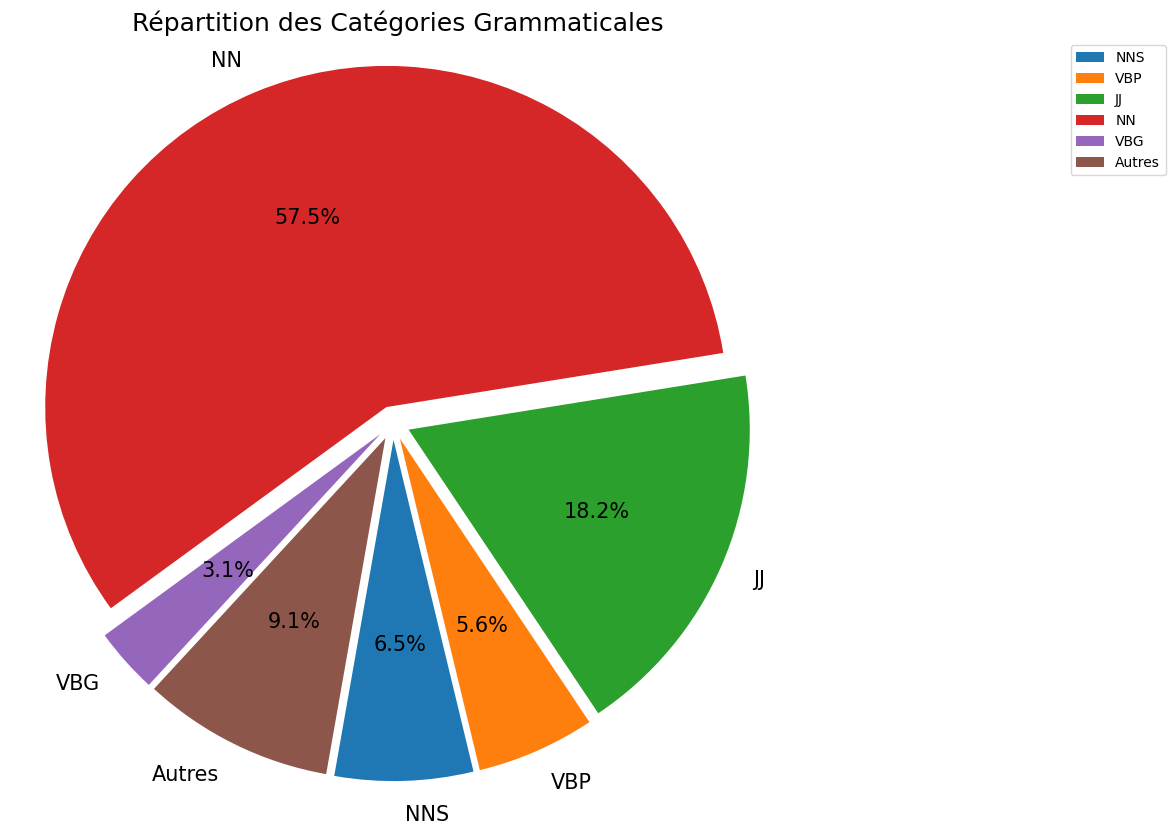

In [15]:
func.plot_pos_pie_chart(filtered_pos_counts)

**Conclusion :**

Les catégories avec les plus grands pourcentages sont :
- **NN (Nouns)** : 57.6%
- **JJ (Adjectives)** : 18.5%
- **NNS (Plural Nouns)** : 6.6%
- **VBP (Verb, non-3rd person singular present)** : 5.5%
- **VBG (Verb, gerund or present participle)** : 3.0%
- **Autres** : 8.9%

Nous allons garder uniquement les noms communs (**NN**) et exclure le reste. Malgré que les adjectifs (**JJ**), les noms pluriels (**NNS**), les verbes au présent non troisième personne du singulier (**VBP**) et les verbes au gérondif ou participe présent (**VBG**) aient des pourcentages relativement élevés, nous préférons les exclure du corpus "Titles" et "Body" pour réduire la dimensionnalité de ces corpus et nous concentrer sur les noms.

## **Nettoyage des textes pour les Title et les Body:**

#### Fonction de nettoyage des textes pour les titles et les bodys

Je vais créer la fonction `process_clean_text` qui nettoie et tokenize le texte en plusieurs étapes :

1. **Normalisation des cas** : Conversion du texte en minuscules pour uniformiser.
2. **Suppression des contractions** : Expansion des contractions anglaises courantes.
3. **Suppression de la ponctuation** : Retrait des caractères non alphanumériques, en conservant certains caractères spéciaux comme `#`.
4. **Suppression des chiffres seuls** : Élimination des nombres isolés dans le texte.
5. **Suppression des espaces supplémentaires** : Réduction des espaces multiples et des espaces en début/fin de texte.
6. **Tokenisation** : Division du texte en mots individuels en utilisant `word_tokenize`.
7. **Remplacement des tokens spécifiques** : Conversion des occurrences de 'c' en 'c#'.
8. **Suppression des stopwords avec spaCy** : Filtrage des mots courants non pertinents en utilisant la liste des stopwords de spaCy.
9. **Filtrage des mots courts** : Suppression des mots de longueur inférieure à `min_len_word`.
10. **Filtrage des tokens selon les catégories grammaticales spécifiées** : Conservation uniquement des noms communs (**NN**), des noms propres (**NNP**) et des noms pluriels (**NNS**).
11. **Lemmatisation** : Réduction des mots à leur forme de base en utilisant WordNet.

Cette fonction permet de nettoyer et de préparer le texte pour des traitements ultérieurs en conservant les éléments pertinents et en éliminant les éléments non pertinents.

In [16]:
# def process_clean_text(doc, rejoin=True, min_len_word=2, stop_words=stop_words):
#     """
#     Fonction de traitement de texte global

#     Arguments :
#     ----------------------
#     doc : str : le document (c'est-à-dire un texte au format str) à traiter

#     rejoin : bool : si True, retourne une chaîne de caractères sinon retourne la liste des tokens
#     min_len_word : int : la longueur minimale des mots à ne pas exclure

#     Les noms, voire certains verbes, permettent de définir ces mots clés. Les adjectifs ou les adverbes sont beaucoup moins pertinents.

#     Retour :
#     -------
#     Une chaîne de caractères (si rejoin est True) ou une liste de tokens
#     """
    
#     # Fonction pour normaliser les cas
#     def case_normalization(text):
#         return text.lower()

#     # Fonction pour supprimer les contractions anglaises (modifiée pour développer les contractions)
#     def remove_contractions(text):
#         contractions_dict = {
#             "can't": "cannot",
#             "won't": "will not",
#             "n't": " not",
#             "'re": " are",
#             "'s": " is",
#             "'d": " would",
#             "'ll": " will",
#             "'t": " not",
#             "'ve": " have",
#             "'m": " am"
#         }
#         for contraction, expansion in contractions_dict.items():
#             text = re.sub(contraction, expansion, text)
#         return text

#     # Fonction pour supprimer la ponctuation (conserver certains caractères)
#     def remove_punctuation(text):
#         return re.sub(r'[^\w\s#+]', '', text)

#     # Nouvelle fonction pour supprimer uniquement les chiffres seuls
#     def remove_numbers(text):
#         return re.sub(r'\b\d+\b', '', text)

#     # Fonction pour supprimer les espaces supplémentaires
#     def remove_extra_spaces(text):
#         return re.sub(r'\s+', ' ', text).strip()

#     # Mise en minuscule, suppression des espaces en trop, des liens et des balises HTML et de code
#     doc = case_normalization(doc)
#     doc = remove_contractions(doc)
#     doc = remove_punctuation(doc)
#     doc = remove_numbers(doc)
#     doc = remove_extra_spaces(doc)

#     # Tokenisation avec word_tokenize
#     raw_tokens_list = word_tokenize(doc)
#     raw_tokens_list = ['c#' if token == 'c' else token for token in raw_tokens_list]

#     # Suppression des stop words avec spaCy
#     cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

#     # Suppression des mots de longueur inférieure à min_len_word
#     more_than_N = [w for w in cleaned_tokens_list if len(w) >= min_len_word]

#     # Fonction pour obtenir la catégorie grammaticale de WordNet
#     def get_wordnet_pos(word):
#         """Retourne la catégorie grammaticale pour la lemmatisation."""
#         tag = pos_tag([word])[0][1]
#         if tag in {'NN', 'NNP', 'NNS'}:
#             return tag
#         return None

#     filtered_tokens = [w for w in more_than_N if get_wordnet_pos(w) in {'NN', 'NNP', 'NNS'}]

#     # Lemmatisation
#     lemmatized_tokens = [lemmatizer.lemmatize(w) for w in filtered_tokens]

#     # Retour du résultat
#     if rejoin:
#         return " ".join(lemmatized_tokens)

#     return lemmatized_tokens

#### Le teste de la fonction:

In [17]:
# Exemple de texte à traiter pour le test
test_paragraph = """
The development of artificial intelligence, particularly in languages like Python , JavaScript and x86, 
has revolutionized the field of technology. Tools such as TensorFlow, PyTorch, and Keras are widely used in the industry for developing 
machine learning models. Moreover, languages like C++ and C# remain crucial for systems programming and game development. 
With the rise of new technologies, the integration of Rust and Go in performance-critical applications has become more common. 
Frameworks like ReactJS and Angular dominate the frontend development landscape, while Node.js and Express are essential for backend services. 
In addition, the popularity of TypeScript has surged due to its ability to add type safety to JavaScript. 
Languages such as Java and Kotlin are extensively used in Android development. 
Furthermore, HTML and CSS are fundamental technologies for web development. 
As cloud computing grows, platforms like AWS, Azure, and Google Cloud provide scalable infrastructure solutions. 
In data science, SQL and NoSQL databases, along with tools like Pandas and NumPy, play a significant role in data manipulation and analysis. 
The DevOps culture is fostered through tools like Docker and Kubernetes, enabling efficient containerization and orchestration of applications. 
Continuous integration and continuous deployment (CI/CD) pipelines have become the backbone of modern software development, with tools such as Jenkins and GitLab CI/CD being widely adopted. 
In 2023, the adoption of artificial intelligence has seen a 50% increase, while cloud services have grown by 25%. 
The number of developers using Python has risen to over 8 million, and JavaScript remains the most popular language with 12 million users worldwide. Visit https://example.com for more details.
"""


# Appliquer la fonction de traitement de texte
processed_text = func.process_clean_text(test_paragraph, rejoin=True, stop_words=stop_words)

# Afficher le résultat
print("Texte traité :", processed_text)

Texte traité : development intelligence language python javascript x86 field technology tool tensorflow pytorch kera industry machine model language c++ c# remain system game development rise technology integration rust application framework reactjs angular dominate frontend development landscape nodejs express backend service addition popularity typescript ability type safety javascript language java kotlin android development html cs technology web development cloud grows platform aws azure google cloud provide infrastructure solution data science sql nosql database tool panda numpy play role data manipulation analysis devops culture tool docker kubernetes efficient containerization orchestration application integration deployment cicd pipeline backbone software development tool jenkins gitlab cicd adoption intelligence increase cloud service grown number developer python risen javascript remains language user worldwide visit httpsexamplecom detail


### **Traiter les Titles:**

#### Créer le corpus title avant le netoyage du texte:

In [18]:
# Combiner tous les titres en une seule chaîne de texte
corpus_titles = " ".join(df['Title'].values).lower()

# Afficher une petite phrase avec les 10 premiers mots du corpus des titres
corpus_titles_tokens = corpus_titles.split()
print("Les 10 premiers mots du corpus des titres sont :", corpus_titles_tokens[:10])


Les 10 premiers mots du corpus des titres sont : ['how', 'do', 'i', 'delete', 'a', 'git', 'branch', 'locally', 'and', 'remotely?']


Création de liste des titles uniques:

In [19]:
# Créer la liste des mots distincts
unique_titles_tokens = list(set(corpus_titles_tokens))

# Afficher une petite phrase avec les 10 premiers mots distincts
print("Les 10 premiers mots distincts sont :", unique_titles_tokens[:10])

# Afficher le nombre total de mots distincts
print("Le nombre total de mots distincts est :", len(unique_titles_tokens))

Les 10 premiers mots distincts sont : ["'jsx,", 'file.jpg', "website's", 'sequence"', 'asp:radiobutton', 'second?', 'veracode', 'marktest.config', 'ended?', 'tdd']
Le nombre total de mots distincts est : 40824


Affichage des value counts du corpus titles:

In [20]:
# Afficher la fréquence de chaque mot dans le corpus des titres
value_counts_titles = pd.Series(corpus_titles_tokens).value_counts()
print("Fréquence de chaque mot dans le corpus des titres :\n", value_counts_titles)

Fréquence de chaque mot dans le corpus des titres :
 to                        20078
in                        15239
how                       13407
a                         12141
the                        7082
                          ...  
boost::shared_ptr?            1
www,                          1
(http:/,                      1
(named                        1
instant.toepochmilli()        1
Length: 40824, dtype: int64


#### Appliquer la fonction de traitement de texte

In [21]:
%%time
# Application de la fonction process_clean_text sur la colonne 'Title'
df['cleaned_title'] = df['Title'].apply(lambda x: func.process_clean_text(x, stop_words=stop_words))

CPU times: total: 1min 20s
Wall time: 1min 24s


In [22]:
print("Avant traitement du Title:")
print('----------------------------')
print(df.Title[0])
print('----------------------------' * 5)
print("Après traitement du Title :")
print('----------------------------')
print(df.cleaned_title[0])
print('----------------------------' * 5)

Avant traitement du Title:
----------------------------
How do I delete a Git branch locally and remotely?
--------------------------------------------------------------------------------------------------------------------------------------------
Après traitement du Title :
----------------------------
delete git branch
--------------------------------------------------------------------------------------------------------------------------------------------


#### Créer le corpus title apres le netoyage du texte:

In [23]:
# Combiner tous les titres en une seule chaîne de texte
corpus_cleaned_titles = " ".join(df['cleaned_title'].values)

# Afficher une petite phrase avec les 10 premiers mots du corpus des titres
corpus_cleaned_titles_tokens = corpus_cleaned_titles.split()

# Afficher la fréquence de chaque mot dans le corpus des titres
value_counts_cleaned_titles = pd.Series(corpus_cleaned_titles_tokens).value_counts()
print("Fréquence de chaque mot dans le corpus des titres :\n", value_counts_cleaned_titles)

Fréquence de chaque mot dans le corpus des titres :
 file                                        3211
error                                       2790
python                                      2118
use                                         1828
value                                       1608
                                            ... 
pagespeed                                      1
beginbackgroundtaskwithexpirationhandler       1
dfappend                                       1
ienumerableselect                              1
instanttoepochmilli                            1
Length: 19786, dtype: int64


In [24]:
# Créer la liste des mots distincts
unique_cleaned_titles_tokens = list(set(corpus_cleaned_titles_tokens))

# Afficher une petite phrase avec les 10 premiers mots distincts
print("Les 10 premiers mots distincts sont :", unique_cleaned_titles_tokens[:10])

# Afficher le nombre total de mots distincts
print("Le nombre total de mots distincts est :", len(unique_cleaned_titles_tokens))

Les 10 premiers mots distincts sont : ['hform', 'chm', 'veracode', 'rtmprtsp', 'forum', 'deleteline', 'tdd', 'built', 'perclass', 'jti']
Le nombre total de mots distincts est : 19786


In [25]:
display(df.head())

,Id,Title,Body,Tags,Score,ViewCount,AnswerCount,split_tags,cleaned_title
0,2003505,How do I delete a Git branch locally and remot...,<p>Failed Attempts to Delete a Remote Branch:<...,<git><version-control><git-branch><git-push><g...,20374,11748306,41,"[git, version, control, git, branch, git, push...",delete git branch
1,16956810,Find all files containing a specific text (str...,<p>How do I find all files containing a specif...,<linux><text><grep><directory><find>,7541,11199700,56,"[linux, text, grep, directory, find]",file text string linux
2,1125968,"How do I force ""git pull"" to overwrite local f...",<p>How do I force an overwrite of local files ...,<git><version-control><overwrite><git-pull><gi...,9728,8715122,54,"[git, version, control, overwrite, git, pull, ...",force git pull overwrite file
3,4366730,How do I check if a string contains a specific...,<p>Consider:</p>\n\n<pre><code>$a = 'How are y...,<php><string><substring><contains><string-matc...,2653,6745591,36,"[php, string, substring, contains, string, mat...",check string contains word
4,11346283,Renaming column names in Pandas,<p>I want to change the column labels of a Pan...,<python><pandas><replace><dataframe><rename>,2997,6602832,33,"[python, pandas, replace, dataframe, rename]",column name panda


#### Le word cloud des titles:

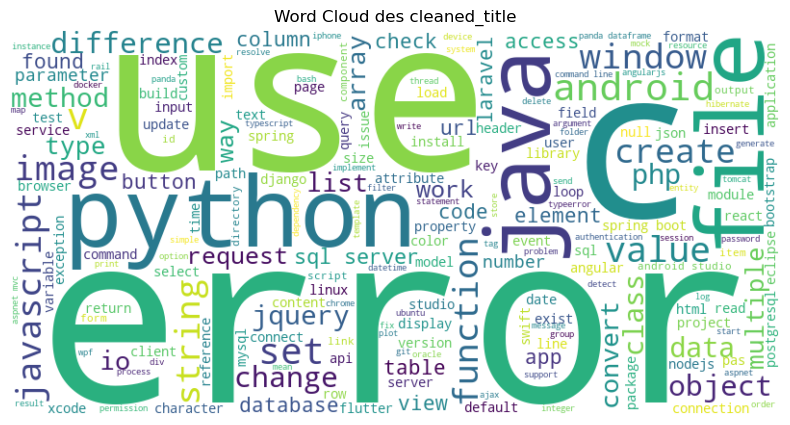

In [27]:
func.generate_wordcloud(df['cleaned_title'].tolist(), title = 'Word Cloud des cleaned_title')

#### Conclusion

Le word cloud des titres nettoyés montre les mots les plus fréquents dans les questions de Stack Overflow :

- **Mots Clés Fréquents** : "error", "use", "server", "python", "java", "file", "convert", "value".
- **Technologies Populaires** : "python", "javascript", "java", "android", "sql", "php", "jquery".
- **Actions Courantes** : "create", "use", "set", "convert", "check", "change", "update".
- **Autres Termes Importants** : "string", "array", "function", "column", "dataframe", "object", "method", "class".

### **Traiter les Body:**

#### Récupérer du texte avec BeautifulSoup pour la colonne Body:

Nous allons nettoyer le texte HTML en supprimant les URLs, les balises `style`, `script` et `code`, tout en conservant le contenu textuel pertinent. Voici les étapes de nettoyage :

1. **Suppression des URLs** : Élimination des liens URL du texte HTML brut.
2. **Analyse robuste du HTML** : Utilisation du parser `lxml` pour une analyse plus fiable du HTML.
3. **Suppression des balises spécifiques** : Retrait des balises `style`, `script` et `code` du texte, car elles ne contiennent pas de texte pertinent.
4. **Récupération du texte nettoyé** : Extraction du texte brut nettoyé en conservant uniquement les éléments textuels pertinents.

In [28]:
# def clean_html(text):
#     """
#     Nettoyer les balises HTML, supprimer les liens et récupérer le texte brut, 
#     tout en conservant les tags spécifiques dans les balises <code>.
    
#     Args:
#         text (str): Texte brut avec HTML.
             
#     Returns:
#         str: Texte nettoyé.
#     """
    
#     # Suppression des URLs du texte HTML brut
#     text = re.sub(r'http[s]?://\S+', '', text)
    
#     # Utilisation du parser lxml pour une analyse plus robuste
#     soup = BeautifulSoup(text, 'lxml')

#     # Suppression des balises <style> , <script> et <code>
#     for element in soup(['style', 'script', 'code']):
#         element.extract()

#     # Récupération du texte nettoyé
#     cleaned_text = soup.get_text(separator=' ')

#     return cleaned_text

#### Application de la fonction clean_html sur la colonne 'Body':

In [29]:
df['cleaned_html_body'] = df['Body'].apply(func.clean_html)

#### Tester un document de Body:

In [30]:
print("Avant traitement du body :")
print('----------------------------')
print(df.Body[1])
print('----------------------------' * 5)
print("Après traitement clean_html du body :")
print('----------------------------')
print(df.cleaned_html_body[1])
print('----------------------------' * 5)

Avant traitement du body :
----------------------------
<p>How do I find all files containing a specific string of text within their file contents?</p>
<p>The following doesn't work. It seems to display every single file in the system.</p>
<pre class="lang-none prettyprint-override"><code>find / -type f -exec grep -H 'text-to-find-here' {} \;
</code></pre>

--------------------------------------------------------------------------------------------------------------------------------------------
Après traitement clean_html du body :
----------------------------
How do I find all files containing a specific string of text within their file contents? 
 The following doesn't work. It seems to display every single file in the system. 
 

--------------------------------------------------------------------------------------------------------------------------------------------


In [31]:
df.head()

,Id,Title,Body,Tags,Score,ViewCount,AnswerCount,split_tags,cleaned_title,cleaned_html_body
0,2003505,How do I delete a Git branch locally and remot...,<p>Failed Attempts to Delete a Remote Branch:<...,<git><version-control><git-branch><git-push><g...,20374,11748306,41,"[git, version, control, git, branch, git, push...",delete git branch,Failed Attempts to Delete a Remote Branch: \n ...
1,16956810,Find all files containing a specific text (str...,<p>How do I find all files containing a specif...,<linux><text><grep><directory><find>,7541,11199700,56,"[linux, text, grep, directory, find]",file text string linux,How do I find all files containing a specific ...
2,1125968,"How do I force ""git pull"" to overwrite local f...",<p>How do I force an overwrite of local files ...,<git><version-control><overwrite><git-pull><gi...,9728,8715122,54,"[git, version, control, overwrite, git, pull, ...",force git pull overwrite file,How do I force an overwrite of local files on ...
3,4366730,How do I check if a string contains a specific...,<p>Consider:</p>\n\n<pre><code>$a = 'How are y...,<php><string><substring><contains><string-matc...,2653,6745591,36,"[php, string, substring, contains, string, mat...",check string contains word,"Consider: \n \n Suppose I have the code above,..."
4,11346283,Renaming column names in Pandas,<p>I want to change the column labels of a Pan...,<python><pandas><replace><dataframe><rename>,2997,6602832,33,"[python, pandas, replace, dataframe, rename]",column name panda,I want to change the column labels of a Pandas...


#### Créer le corpus body avant le netoyage du texte:

In [32]:
# Combiner tout le contenu des corps de texte nettoyés en une seule chaîne de texte
corpus_cleaned_html_body = " ".join(df['cleaned_html_body'].values).lower()

# Afficher une petite phrase avec les 10 premiers mots du corpus des corps de texte nettoyés
corpus_cleaned_html_body_tokens = corpus_cleaned_html_body.split()
print("Les 10 premiers mots du corpus des corps de texte nettoyés sont :", corpus_cleaned_html_body_tokens[:10])

# Afficher le nombre total de mots du corpus Body
print("Le nombre total de mots du corpus Body est :", len(corpus_cleaned_html_body))

Les 10 premiers mots du corpus des corps de texte nettoyés sont : ['failed', 'attempts', 'to', 'delete', 'a', 'remote', 'branch:', 'how', 'do', 'i']
Le nombre total de mots du corpus Body est : 26282963


In [33]:
# Afficher la fréquence de chaque mot dans le corpus des corps de texte nettoyés
value_cleaned_html_body_body = pd.Series(corpus_cleaned_html_body_tokens).value_counts()
print("Fréquence de chaque mot dans le corpus des corps de texte nettoyés :\n", value_cleaned_html_body_body)

Fréquence de chaque mot dans le corpus des corps de texte nettoyés :
 the                          240533
i                            190969
to                           166093
a                            108700
is                            88480
                              ...  
sonarqubesetting                  1
sonar.coverage.exclusions         1
useless..                         1
multi-thread                      1
myapp.js                          1
Length: 170966, dtype: int64


Création de la liste des bodys unique:

In [34]:
# Créer la liste des mots distincts
unique_cleaned_html_body_tokens = list(set(corpus_cleaned_html_body_tokens))

# Afficher une petite phrase avec les 10 premiers mots distincts
print("Les 10 premiers mots distincts sont :", unique_cleaned_html_body_tokens[:10])

# Afficher le nombre total de mots distincts
print("Le nombre total de mots distincts est :", len(unique_cleaned_html_body_tokens))

Les 10 premiers mots distincts sont : ["website's", '\\xampp\\php\\ext\\mbstring', 'subclass,', "program's", 'himself:', 'berry', 'me!!!', '960px,', '.login', '(index.js?ts=1649816623582:5680:1)']
Le nombre total de mots distincts est : 170966


Affichage des value counts du corpus Bodys:

In [35]:
# Afficher la fréquence de chaque mot dans le corpus des corps de texte nettoyés
value_counts_cleaned_html_body = pd.Series(corpus_cleaned_html_body_tokens).value_counts()
print("Fréquence de chaque mot dans le corpus des corps de texte nettoyés :\n", value_counts_cleaned_html_body)

Fréquence de chaque mot dans le corpus des corps de texte nettoyés :
 the                          240533
i                            190969
to                           166093
a                            108700
is                            88480
                              ...  
sonarqubesetting                  1
sonar.coverage.exclusions         1
useless..                         1
multi-thread                      1
myapp.js                          1
Length: 170966, dtype: int64


#### Application de la fonction process_clean_text sur la colonne 'cleaned_html_body':

In [36]:
%%time
df['cleaned_body'] = df['cleaned_html_body'].apply(lambda x: func.process_clean_text(x, stop_words=stop_words))

CPU times: total: 9min 1s
Wall time: 9min 19s


In [37]:
display(df.head())

,Id,Title,Body,Tags,Score,ViewCount,AnswerCount,split_tags,cleaned_title,cleaned_html_body,cleaned_body
0,2003505,How do I delete a Git branch locally and remot...,<p>Failed Attempts to Delete a Remote Branch:<...,<git><version-control><git-branch><git-push><g...,20374,11748306,41,"[git, version, control, git, branch, git, push...",delete git branch,Failed Attempts to Delete a Remote Branch: \n ...,attempt delete remote branch delete branch
1,16956810,Find all files containing a specific text (str...,<p>How do I find all files containing a specif...,<linux><text><grep><directory><find>,7541,11199700,56,"[linux, text, grep, directory, find]",file text string linux,How do I find all files containing a specific ...,file string text file content work display fil...
2,1125968,"How do I force ""git pull"" to overwrite local f...",<p>How do I force an overwrite of local files ...,<git><version-control><overwrite><git-pull><gi...,9728,8715122,54,"[git, version, control, overwrite, git, pull, ...",force git pull overwrite file,How do I force an overwrite of local files on ...,force overwrite file repository contains file ...
3,4366730,How do I check if a string contains a specific...,<p>Consider:</p>\n\n<pre><code>$a = 'How are y...,<php><string><substring><contains><string-matc...,2653,6745591,36,"[php, string, substring, contains, string, mat...",check string contains word,"Consider: \n \n Suppose I have the code above,...",suppose code correct way write statement
4,11346283,Renaming column names in Pandas,<p>I want to change the column labels of a Pan...,<python><pandas><replace><dataframe><rename>,2997,6602832,33,"[python, pandas, replace, dataframe, rename]",column name panda,I want to change the column labels of a Pandas...,want change column label panda dataframe


#### Créer le corpus body après le netoyage du texte:

In [38]:
# Combiner tout le contenu des corps de texte nettoyés en une seule chaîne de texte
corpus_cleaned_body = " ".join(df['cleaned_body'].values).lower()

# Afficher une petite phrase avec les 10 premiers mots du corpus des corps de texte nettoyés
corpus_cleaned_body_tokens = corpus_cleaned_body.split()
print("Les 10 premiers mots du corpus des corps de texte nettoyés sont :", corpus_cleaned_body_tokens[:10])

# Afficher le nombre total de mots du corpus Body
print("Le nombre total de mots du corpus Body est :", len(corpus_cleaned_body))

Les 10 premiers mots du corpus des corps de texte nettoyés sont : ['attempt', 'delete', 'remote', 'branch', 'delete', 'branch', 'file', 'string', 'text', 'file']
Le nombre total de mots du corpus Body est : 10550810


In [39]:
# Afficher la fréquence de chaque mot dans le corpus des corps de texte nettoyés
value_counts_cleaned_body = pd.Series(corpus_cleaned_body_tokens).value_counts()
print("Fréquence de chaque mot dans le corpus des corps de texte nettoyés :\n", value_counts_cleaned_body[:20])

Fréquence de chaque mot dans le corpus des corps de texte nettoyés :
 code           21019
file           20786
error          19203
use            16936
want           16430
work           14763
way            12665
need           11756
problem        10192
data            9608
value           8694
server          8320
function        7977
method          7890
example         7731
user            7652
class           7320
help            7106
application     7094
set             6952
dtype: int64


In [40]:
# Créer la liste des mots distincts
unique_cleaned_body_tokens = list(set(corpus_cleaned_body_tokens))

# Afficher une petite phrase avec les 10 premiers mots distincts
print("Les 10 premiers mots distincts sont :", unique_cleaned_body_tokens[:10])

# Afficher le nombre total de mots distincts
print("Le nombre total de mots distincts est :", len(unique_cleaned_body_tokens))

Les 10 premiers mots distincts sont : ['isystemweb', 'customdrawn', 'mysampleoxy', 'abcdefg', 'withoutpdomssql', 'javaspringproject', 'self_handle_key_loading_error', 'encryptfiles', 'activity_mailxml', 'acmecom']
Le nombre total de mots distincts est : 70710


In [41]:
df.head()

,Id,Title,Body,Tags,Score,ViewCount,AnswerCount,split_tags,cleaned_title,cleaned_html_body,cleaned_body
0,2003505,How do I delete a Git branch locally and remot...,<p>Failed Attempts to Delete a Remote Branch:<...,<git><version-control><git-branch><git-push><g...,20374,11748306,41,"[git, version, control, git, branch, git, push...",delete git branch,Failed Attempts to Delete a Remote Branch: \n ...,attempt delete remote branch delete branch
1,16956810,Find all files containing a specific text (str...,<p>How do I find all files containing a specif...,<linux><text><grep><directory><find>,7541,11199700,56,"[linux, text, grep, directory, find]",file text string linux,How do I find all files containing a specific ...,file string text file content work display fil...
2,1125968,"How do I force ""git pull"" to overwrite local f...",<p>How do I force an overwrite of local files ...,<git><version-control><overwrite><git-pull><gi...,9728,8715122,54,"[git, version, control, overwrite, git, pull, ...",force git pull overwrite file,How do I force an overwrite of local files on ...,force overwrite file repository contains file ...
3,4366730,How do I check if a string contains a specific...,<p>Consider:</p>\n\n<pre><code>$a = 'How are y...,<php><string><substring><contains><string-matc...,2653,6745591,36,"[php, string, substring, contains, string, mat...",check string contains word,"Consider: \n \n Suppose I have the code above,...",suppose code correct way write statement
4,11346283,Renaming column names in Pandas,<p>I want to change the column labels of a Pan...,<python><pandas><replace><dataframe><rename>,2997,6602832,33,"[python, pandas, replace, dataframe, rename]",column name panda,I want to change the column labels of a Pandas...,want change column label panda dataframe


#### Le word cloud des bodys:

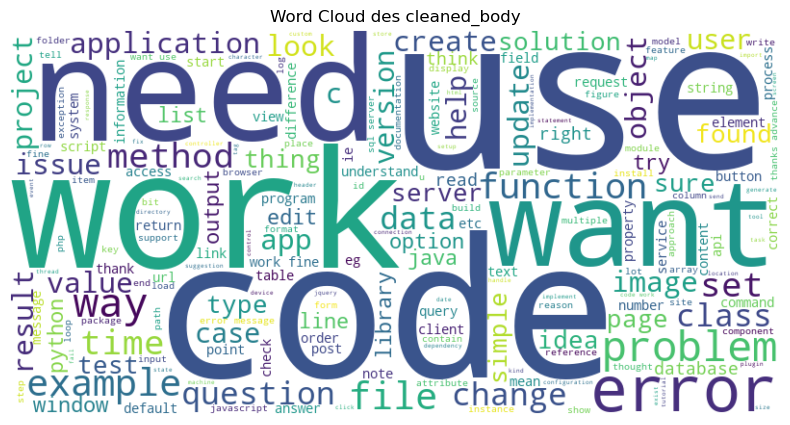

In [43]:
func.generate_wordcloud(df['cleaned_body'].tolist(), title= 'Word Cloud des cleaned_body')

Selon le word cloud des corps de texte nettoyés, certains mots très fréquents ne seront pas pertinents pour l'analyse LDA. Par conséquent, je préfère les ajouter à la liste des stop words de Spacy. Cela permettra de filtrer les termes génériques ou redondants, améliorant ainsi la pertinence des sujets extraits par l'analyse LDA. Ce processus contribue à mettre en lumière des thèmes plus spécifiques et informatifs qui sont cruciaux pour une compréhension plus approfondie des données de la colonne `cleaned_body`:

In [44]:
# Liste étendue des mots à ajouter à la liste des stop words
custom_stop_words = [
    'want', 'need', 'work', 'way', 'problem', 'fine','sure', 'example', 'create'
    
]

# Ajouter chaque mot personnalisé dans la liste des stop words
for word in custom_stop_words:
    nlp.Defaults.stop_words.add(word)
    nlp.vocab[word].is_stop = True

In [45]:
# Fonction pour retirer les stop words
def remove_stop_words(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_stop])

In [46]:
%%time
# Appliquer la fonction pour nettoyer les titres
df['cleaned_body'] = df['cleaned_body'].apply(remove_stop_words)

CPU times: total: 4min 12s
Wall time: 4min 21s


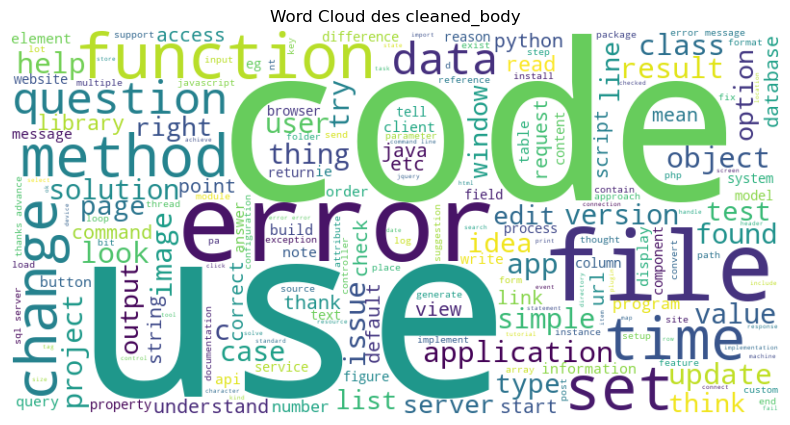

In [47]:
func.generate_wordcloud(df['cleaned_body'].tolist(), title= 'Word Cloud des cleaned_body')

#### Conclusion

Le word cloud des corps de texte nettoyés montre les mots les plus fréquents dans les questions de Stack Overflow :

- **Mots Clés Fréquents** : "user", "error", "code", "function", "set", "method", "python".
- **Actions Courantes** : "read", "help", "use", "update", "edit", "fix", "change", "check".
- **Concepts et Structures** : "application", "page", "object", "output", "issue", "project", "database", "version".

## **Visualisation des Données numériques:**

#### Histogrammes des 3 variables numériques : 'Score', 'ViewCount', 'AnswerCount'

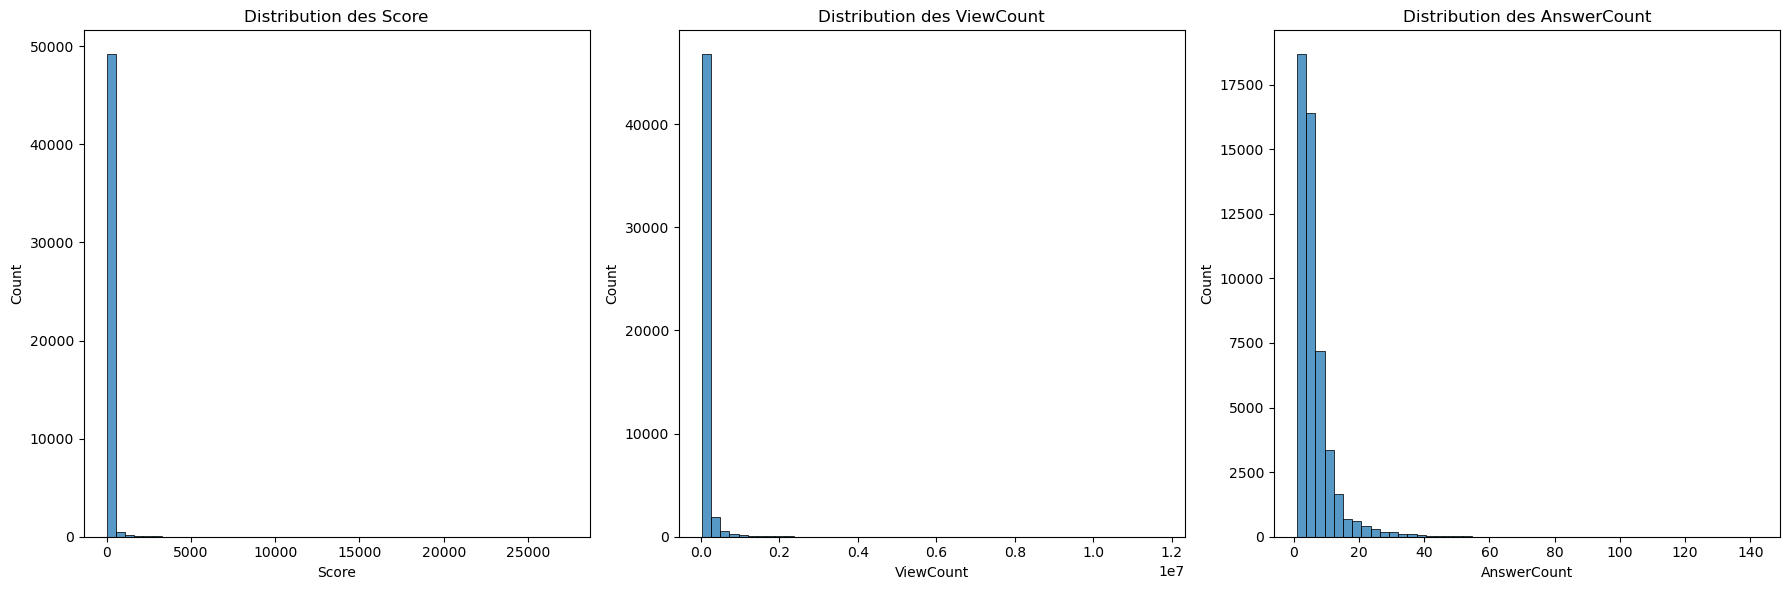

In [48]:
func.plot_histograms(df, ['Score', 'ViewCount', 'AnswerCount'])

#### **Conclusion**

Les histogrammes des variables Score, ViewCount et AnswerCount montrent que la majorité des observations sont concentrées dans les gammes basses, avec une présence notable de valeurs extrêmes élevées qui apparaissent comme des exceptions.

- **Score** : La grande majorité des questions reçoivent un score proche de 0, indiquant peu ou pas de votes positifs, tandis que très peu atteignent des scores élevés.
- **ViewCount** : Les vues sont majoritairement faibles pour la plupart des questions, avec une forte concentration près de l'extrémité inférieure de l'échelle, bien que quelques questions atteignent des nombres de vues exceptionnellement élevés.
- **AnswerCount** : La plupart des questions reçoivent entre 0 et 5 réponses, illustrant un engagement limité, avec seulement quelques questions recevant un nombre de réponses bien plus élevé.

Ces distributions suggèrent que l'activité autour des questions (mesurée par les scores, les vues et les réponses) est majoritairement limitée à un petit ensemble de questions très populaires, tandis que la grande majorité des questions reste relativement ignorée ou peu engageante pour la communauté.

#### **Boîte à moustaches:**

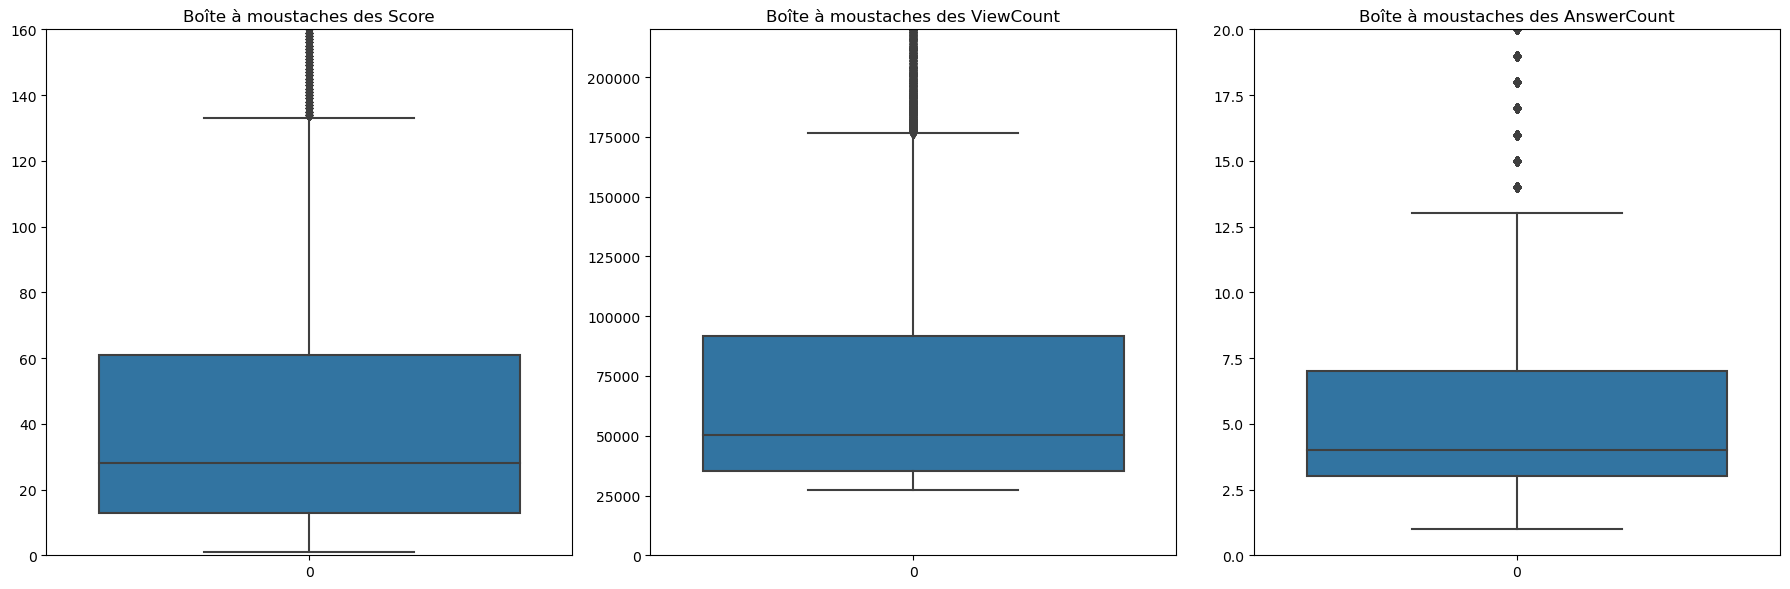

In [49]:
y_limits = {
    'Score': (0, 160),
    'ViewCount': (0, 220000),
    'AnswerCount': (0, 20)
}
func.plot_boxplots(df, ['Score', 'ViewCount', 'AnswerCount'], y_limits)

#### **Conclusion**

Les boîtes à moustaches des variables `Score`, `ViewCount`, et `AnswerCount` montrent une distribution inégale avec de nombreuses valeurs extrêmes.

- **Score** : La majorité des scores sont en dessous de 40, avec quelques valeurs extrêmes allant jusqu'à 160.
- **ViewCount** : La majorité des questions ont moins de 75,000 vues, avec quelques valeurs atteignant jusqu'à environ 200,000.
- **AnswerCount** : La plupart des questions ont entre 0 et 5 réponses, avec quelques valeurs extrêmes allant jusqu'à 20.

Ces distributions indiquent que l'activité (votes, vues, réponses) est concentrée sur un petit nombre de questions populaires, tandis que la majorité des questions reçoivent peu d'attention.

#### Matrice de corrélation:

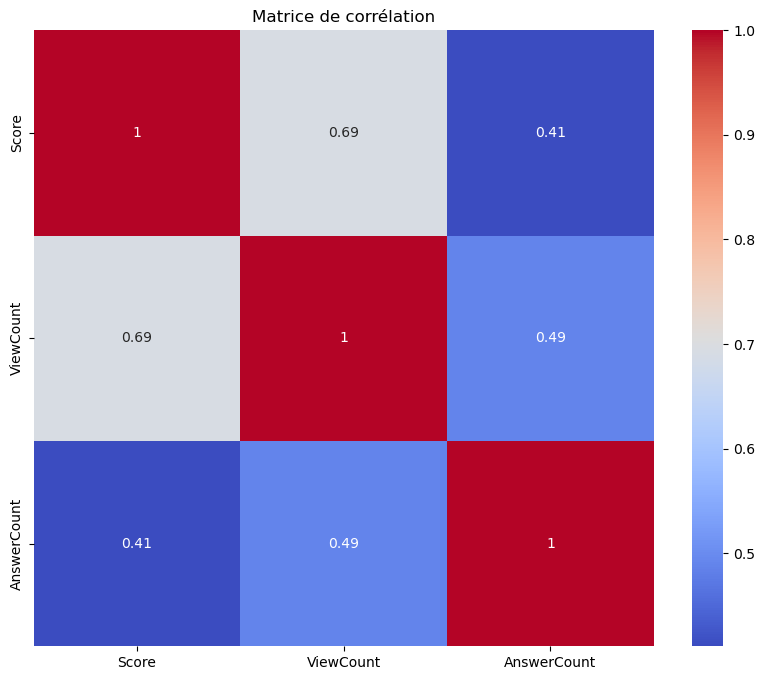

In [50]:
func.plot_correlation_matrix(df, ['Score', 'ViewCount', 'AnswerCount'])

#### **Conclusion**

La matrice de corrélation présentée montre les corrélations entre les variables `Score`, `ViewCount`, et `AnswerCount`. Voici l'interprétation des coefficients de corrélation affichés :

- **Score et ViewCount** : La corrélation est de 0.69, ce qui indique une forte corrélation positive. Cela signifie que les éléments avec un nombre élevé de vues tendent également à avoir des scores plus élevés.
- **Score et AnswerCount** : La corrélation est de 0.41, ce qui indique une corrélation modérée positive. Cela suggère que les éléments avec un nombre plus élevé de réponses ont tendance à avoir des scores plus élevés, bien que cette relation soit moins forte comparée à celle entre `Score` et `ViewCount`.
- **ViewCount et AnswerCount** : La corrélation est de 0.49, ce qui montre une corrélation modérée positive. Cela indique que les éléments avec plus de vues tendent également à recevoir plus de réponses.

#### **Conclusion Générale**

Les corrélations positives entre les variables `Score`, `ViewCount`, et `AnswerCount` indiquent que les éléments populaires (ceux ayant un nombre élevé de vues et de réponses) sont également ceux qui ont tendance à obtenir des scores élevés. Cependant, les corrélations ne sont pas parfaites, ce qui suggère que d'autres facteurs peuvent également influencer ces métriques.

#### Crétion de la nouvelle colonne combined_title_body:

In [51]:
df['combined_title_body'] = df.apply(lambda x: x['cleaned_title'] + ' ' + x['cleaned_body'] if x['cleaned_title'] == x['cleaned_title'] else x['cleaned_body'], axis=1)

In [52]:
display(df.head())

,Id,Title,Body,Tags,Score,ViewCount,AnswerCount,split_tags,cleaned_title,cleaned_html_body,cleaned_body,combined_title_body
0,2003505,How do I delete a Git branch locally and remot...,<p>Failed Attempts to Delete a Remote Branch:<...,<git><version-control><git-branch><git-push><g...,20374,11748306,41,"[git, version, control, git, branch, git, push...",delete git branch,Failed Attempts to Delete a Remote Branch: \n ...,attempt delete remote branch delete branch,delete git branch attempt delete remote branch...
1,16956810,Find all files containing a specific text (str...,<p>How do I find all files containing a specif...,<linux><text><grep><directory><find>,7541,11199700,56,"[linux, text, grep, directory, find]",file text string linux,How do I find all files containing a specific ...,file string text file content display file system,file text string linux file string text file c...
2,1125968,"How do I force ""git pull"" to overwrite local f...",<p>How do I force an overwrite of local files ...,<git><version-control><overwrite><git-pull><gi...,9728,8715122,54,"[git, version, control, overwrite, git, pull, ...",force git pull overwrite file,How do I force an overwrite of local files on ...,force overwrite file repository contains file ...,force git pull overwrite file force overwrite ...
3,4366730,How do I check if a string contains a specific...,<p>Consider:</p>\n\n<pre><code>$a = 'How are y...,<php><string><substring><contains><string-matc...,2653,6745591,36,"[php, string, substring, contains, string, mat...",check string contains word,"Consider: \n \n Suppose I have the code above,...",suppose code correct write statement,check string contains word suppose code correc...
4,11346283,Renaming column names in Pandas,<p>I want to change the column labels of a Pan...,<python><pandas><replace><dataframe><rename>,2997,6602832,33,"[python, pandas, replace, dataframe, rename]",column name panda,I want to change the column labels of a Pandas...,change column label panda dataframe,column name panda change column label panda da...


## Diviser les données en train et test:

In [53]:
df_select = df[['Id','cleaned_title', 'cleaned_body', 'combined_title_body', 'split_tags']]

In [54]:
train_df, test_df = train_test_split(df_select, test_size=0.2, random_state=42)

### Initialiser les vectorizers:

In [55]:
vectorizer = TfidfVectorizer()

#### 1. Bag of Words sur "Title"

In [56]:
vectorizer.fit(train_df['cleaned_title'])
title_bow_train = vectorizer.transform(train_df['cleaned_title'])
title_bow_test = vectorizer.transform(test_df['cleaned_title'])

#### 2. Bag of Words sur "Title" + "Body"

In [57]:
combined_text_train = train_df['combined_title_body']
combined_text_test = test_df['combined_title_body']

In [58]:
display(combined_text_train.head())

39087    xcode iphone simulator look iphone question de...
30893    building dockerfile aptget update jailing proc...
45278    aadsts9002326 crossorigin token redemption isi...
16398    choose tesseract opencv tesseract opencv look ...
13653    mysqlerror key max key length byte cause database
Name: combined_title_body, dtype: object

In [59]:
display(combined_text_test.head())

33553    weight_decay meta parameter caffe bvlccaffe gi...
9427     pyspark dataframe sqllike clause filter pyspar...
199      set contenttype header httpclient request set ...
12447    aspnet web api operationcanceledexception brow...
39489    draw line object line control window form draw...
Name: combined_title_body, dtype: object

In [60]:
vectorizer.fit(combined_text_train)
combined_bow_train = vectorizer.transform(combined_text_train)
combined_bow_test = vectorizer.transform(combined_text_test)

#### 3. Bag of Words avec fit sur "Title" et transform sur "Title" + "Body"

In [61]:
vectorizer.fit(train_df['cleaned_title'])
combined_bow_train_title_fit = vectorizer.transform(combined_text_train)
combined_bow_test_title_fit = vectorizer.transform(combined_text_test)

#### Affichage des shapes des matrices obtenues

In [62]:
print("Title BOW train shape:", title_bow_train.shape)
print("Title BOW test shape:", title_bow_test.shape)
print("Combined BOW train shape:", combined_bow_train.shape)
print("Combined BOW test shape:", combined_bow_test.shape)
print("Combined BOW train (Title fit) shape:", combined_bow_train_title_fit.shape)
print("Combined BOW test (Title fit) shape:", combined_bow_test_title_fit.shape)


Title BOW train shape: (40000, 17079)
Title BOW test shape: (10000, 17079)
Combined BOW train shape: (40000, 64494)
Combined BOW test shape: (10000, 64494)
Combined BOW train (Title fit) shape: (40000, 17079)
Combined BOW test (Title fit) shape: (10000, 17079)


#### Conclusion

Les différentes approches de transformation Bag of Words sur les données textuelles (`Title`, `Body`) produisent des matrices de dimensions variées :

1. **Bag of Words sur "Title"** :
   - Dimensions : `(40000, 17079)` pour l'entraînement et `(10000, 17079)` pour le test.
   - Moins complexe, avec un vocabulaire de taille raisonnable.

2. **Bag of Words sur "Title" + "Body"** :
   - Dimensions : `(40000, 64494)` pour l'entraînement et `(10000, 64494)` pour le test.
   - Très riche en features mais avec une grande dimensionnalité, plus gourmande en ressources.

3. **Fit sur "Title" et Transform sur "Title" + "Body"** :
   - Dimensions : `(40000, 17079)` pour l'entraînement et `(10000, 17079)` pour le test.
   - Compromis entre richesse des features et complexité, appliquant le vocabulaire concis des titres aux combinaisons des titres et des corps.

### Recommandation

- **Approche recommandée : Fit sur "Title" et Transform sur "Title" + "Body"**.
  - **Pourquoi ?** :
    - **Compromis idéal** : Cette approche capte les informations additionnelles des corps des questions tout en maintenant une dimensionnalité plus gérable, utilisant un vocabulaire concis appris à partir des titres.
    - **Efficacité computationnelle** : Elle permet de bénéficier d'une richesse de features sans exiger autant de ressources que l'approche combinée de "Title" + "Body".

Cette méthode offre un bon équilibre entre performance et complexité, rendant les modèles de machine learning plus efficaces et plus rapides à entraîner.

#### Filtrage des colonnes avant sauvegarde :

In [63]:
data = df[['Id','cleaned_title', 'cleaned_body', 'combined_title_body', 'split_tags']]
train_data = train_df
test_data = test_df

In [64]:
display(data.head())

,Id,cleaned_title,cleaned_body,combined_title_body,split_tags
0,2003505,delete git branch,attempt delete remote branch delete branch,delete git branch attempt delete remote branch...,"[git, version, control, git, branch, git, push..."
1,16956810,file text string linux,file string text file content display file system,file text string linux file string text file c...,"[linux, text, grep, directory, find]"
2,1125968,force git pull overwrite file,force overwrite file repository contains file ...,force git pull overwrite file force overwrite ...,"[git, version, control, overwrite, git, pull, ..."
3,4366730,check string contains word,suppose code correct write statement,check string contains word suppose code correc...,"[php, string, substring, contains, string, mat..."
4,11346283,column name panda,change column label panda dataframe,column name panda change column label panda da...,"[python, pandas, replace, dataframe, rename]"


In [65]:
display(train_data.head())

,Id,cleaned_title,cleaned_body,combined_title_body,split_tags
39087,19245853,xcode iphone simulator look iphone,question device appearance iphone simulator xc...,xcode iphone simulator look iphone question de...,"[ios, iphone, xcode, ios, simulator, instruments]"
30893,55921515,building dockerfile aptget update jailing proc...,docker host ubuntu docker snap dockerfile comm...,building dockerfile aptget update jailing proc...,"[docker, ubuntu, nginx, dockerfile, apt]"
45278,72575793,aadsts9002326 crossorigin token redemption isi...,send cross origin request access token react s...,aadsts9002326 crossorigin token redemption isi...,"[javascript, reactjs, webpack, axios, umijs]"
16398,11489824,choose tesseract opencv,tesseract opencv look tesseract ocr engine ope...,choose tesseract opencv tesseract opencv look ...,"[python, opencv, computer, vision, ocr, tesser..."
13653,3489041,mysqlerror key max key length byte,cause database,mysqlerror key max key length byte cause database,"[mysql, sql, ruby, on, rails, indexing, mysql,..."


In [66]:
display(test_data.head())

,Id,cleaned_title,cleaned_body,combined_title_body,split_tags
33553,32177764,weight_decay meta parameter caffe,bvlccaffe git training meta parameter meta par...,weight_decay meta parameter caffe bvlccaffe gi...,"[machine, learning, neural, network, deep, lea..."
9427,35870760,pyspark dataframe sqllike clause,filter pyspark dataframe sqllike clause tuple ...,pyspark dataframe sqllike clause filter pyspar...,"[python, sql, apache, spark, dataframe, pyspark]"
199,10679214,set contenttype header httpclient request,set header object api allows header try throw ...,set contenttype header httpclient request set ...,"[c#, aspnet, rest, content, type, dotnet, http..."
12447,22157596,aspnet web api operationcanceledexception brow...,user load page ajax request hit aspnet web api...,aspnet web api operationcanceledexception brow...,"[aspnet, iis, aspnet, web, api, task, parallel..."
39489,6100573,draw line object,line control window form draw line line,draw line object line control window form draw...,"[c#, winforms, user, interface, drawing, 2d]"


### Sauvegarder les dataset nettoyés :

In [67]:
df_select.to_csv("data/stack_overflow_data_cleaned.csv", index=False)

In [68]:
train_data.to_csv("data/stack_overflow_data_cleaned_train.csv", index=False)

In [69]:
test_data.to_csv("data/stack_overflow_data_cleaned_test.csv", index=False)

J'ai remarqué qu'après avoir stocké les 3 DataFrames, certaines lignes contiennent des valeurs manquantes. Je vais donc les charger pour vérifier ces valeurs manquantes et les supprimer:

In [70]:
df = pd.read_csv('data/stack_overflow_data_cleaned.csv')
func.taux_de_Remplissage_tableau(df, affichage_all = True)

,Colonne,Taux_de_Remplissage
0,Id,100.000
1,combined_title_body,100.000
2,split_tags,100.000
3,cleaned_title,99.952
4,cleaned_body,99.764


In [71]:
train_df = pd.read_csv("data/stack_overflow_data_cleaned_train.csv")
func.taux_de_Remplissage_tableau(train_df, affichage_all = True)

,Colonne,Taux_de_Remplissage
0,Id,100.0000
1,combined_title_body,100.0000
2,split_tags,100.0000
3,cleaned_title,99.9475
4,cleaned_body,99.7550


In [72]:
test_df = pd.read_csv("data/stack_overflow_data_cleaned_test.csv")
func.taux_de_Remplissage_tableau(test_df, affichage_all = True)

,Colonne,Taux_de_Remplissage
0,Id,100.00
1,combined_title_body,100.00
2,split_tags,100.00
3,cleaned_title,99.97
4,cleaned_body,99.80


#### Suppression des valeurs manquantes sur la colonne cleaned_title et cleaned_body:

In [73]:
df = df.dropna()
train_df = train_df.dropna()
test_df = test_df.dropna()

In [74]:
print("La taille du dataset df après suppressions des valeurs manquantes : ", df.shape)
print("La taille du dataset train_df après suppressions des valeurs manquantes : ", train_df.shape)
print("La taille du dataset test_df après suppressions des valeurs manquantes : ", test_df.shape)
df.to_csv("data/stack_overflow_data_cleaned.csv", index=False)
train_df.to_csv("data/stack_overflow_data_cleaned_train.csv", index=False)
test_df.to_csv("data/stack_overflow_data_cleaned_test.csv", index=False)

La taille du dataset df après suppressions des valeurs manquantes :  (49858, 5)
La taille du dataset train_df après suppressions des valeurs manquantes :  (39881, 5)
La taille du dataset test_df après suppressions des valeurs manquantes :  (9977, 5)
